In [1]:
using PorousMaterials
using JLD2
using PyPlot
using PyCall
using CSV
using DataFrames
using StatsBase
using Formatting

using ScikitLearn # machine learning package
using ScikitLearn.CrossValidation: train_test_split
@sk_import gaussian_process : GaussianProcessRegressor
@sk_import gaussian_process.kernels : Matern

┌ Warning: Error requiring `OffsetArrays` from `ArrayInterface`
│   exception = (UndefVarError(:IdOffsetRange), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007f79942cccef, Ptr{Nothing} @0x00007f799435fd24, Ptr{Nothing} @0x00007f798587bda2, Ptr{Nothing} @0x00007f7994342769, Ptr{Nothing} @0x00007f799435ef15, Ptr{Nothing} @0x00007f799435ebce, Ptr{Nothing} @0x00007f799435f811, Ptr{Nothing} @0x00007f7994360297, Base.InterpreterIP in top-level CodeInfo for ArrayInterface at statement 11, Ptr{Nothing} @0x00007f799437bb31, Ptr{Nothing} @0x00007f799437d949, Ptr{Nothing} @0x00007f793c7a72b1, Ptr{Nothing} @0x00007f793c7a72dc, Ptr{Nothing} @0x00007f7994342769, Ptr{Nothing} @0x00007f799435ef15, Ptr{Nothing} @0x00007f799435ebce, Ptr{Nothing} @0x00007f799435f811, Ptr{Nothing} @0x00007f799435fb90, Ptr{Nothing} @0x00007f799436004a, Base.InterpreterIP in MethodInstance for err(::Any, ::Module, ::String) at statement 2, Ptr{Nothing} @0x00007f793c7a7227, Ptr{Nothing} @0x00007f793c7a723c, Ptr

PyObject <class 'sklearn.gaussian_process.kernels.Matern'>

Scikitlearn takes as input:

- a feature matrix X, which must be n_samples by n_features
- a target vector y, which must be n_samples long (of course)

In [2]:
@load joinpath(pwd(), "targets_and_normalized_features.jld2") X henry_y gcmc_y

3-element Vector{Symbol}:
 :X
 :henry_y
 :gcmc_y

In [3]:
###
#  Spit data into training and testing sets
###
henry_X_train, henry_X_test, henry_y_train, henry_y_test = train_test_split(X, henry_y, test_size=0.4)

gcmc_X_train, gcmc_X_test, gcmc_y_train, gcmc_y_test = train_test_split(X, gcmc_y, test_size=0.4)

###
#  Construct GP 
###
henry_kernel = Matern(nu=2.5, length_scale=0.25) 
henry_gpr = GaussianProcessRegressor(kernel=henry_kernel, normalize_y=true, n_restarts_optimizer=5)

gcmc_kernel = Matern(nu=2.5, length_scale=0.25) 
gcmc_gpr  = GaussianProcessRegressor(kernel=gcmc_kernel, normalize_y=true, n_restarts_optimizer=5)

###
#  Train GP on data 
###
henry_gpr.fit(henry_X_train, henry_y_train)
println("Henry - post fit kernel:\t", henry_gpr.kernel_)

gcmc_gpr.fit(gcmc_X_train, gcmc_y_train)
println("GCMC  - post fit kernel:\t", gcmc_gpr.kernel_)

###
#  predictions on test data using trained GP
###
henry_y_pred, henry_y_std = henry_gpr.predict(henry_X_test, return_std=true, return_cov=false)

gcmc_y_pred, gcmc_y_std = gcmc_gpr.predict(gcmc_X_test, return_std=true, return_cov=false);

###
#  Compute statistics about the fit - 
#      RMSE, R2, and Spearman rank
###
henry_rmse = sqrt(mean((henry_y_test - henry_y_pred).^2))
henry_r2 = henry_gpr.score(henry_X_test, henry_y_test)
henry_corspearman = corspearman(henry_y_test, henry_y_pred)

gcmc_rmse = sqrt(mean((gcmc_y_test - gcmc_y_pred).^2))
gcmc_r2 = gcmc_gpr.score(gcmc_X_test, gcmc_y_test)
gcmc_corspearman = corspearman(gcmc_y_test, gcmc_y_pred);

Henry - post fit kernel:	PyObject Matern(length_scale=0.135, nu=2.5)
GCMC  - post fit kernel:	PyObject Matern(length_scale=0.145, nu=2.5)


# Parity Plots

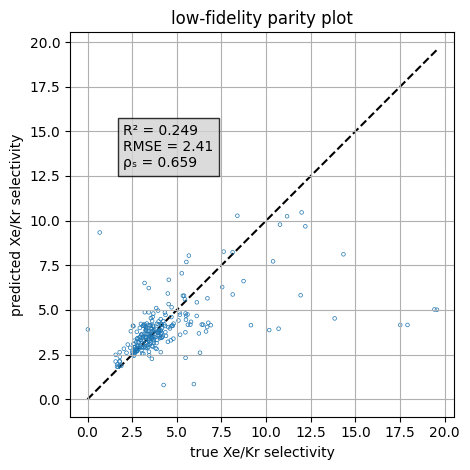

In [4]:
figure()

xmax = maximum(max.(henry_y_test, henry_y_pred))
x = range(0.0, stop=xmax, length=length(henry_y_test))
y = x
plot(x, y, color="k", linestyle="--", zorder=0)

scatter(henry_y_test, henry_y_pred, facecolor="none", edgecolor="C0", linewidth=0.5, s=7)

str = format("R² = {:0.3f}\nRMSE = {:0.2f}\nρₛ = {:0.3f}", henry_r2, henry_rmse, henry_corspearman)
box_styl = Dict(:facecolor => "lightgrey", :alpha => 0.8)
text(2, 13, str, color="k", bbox=box_styl)

grid("on")
gca().set_aspect("equal", adjustable="box")

title("low-fidelity parity plot")
xlabel("true Xe/Kr selectivity")
ylabel("predicted Xe/Kr selectivity")

tight_layout()
savefig(joinpath(pwd(), "figs", "henry_selectivity_parity_plot.png"), dpi=600, format="png")

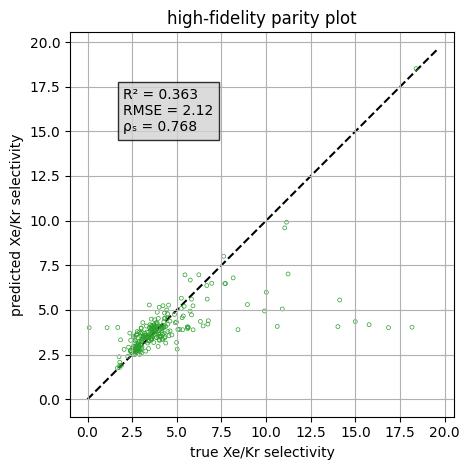

In [5]:
fig = figure()

xmin = minimum(min.(gcmc_y_test, gcmc_y_pred))
# xmax = maximum(max.(gcmc_y_test, gcmc_y_pred))
x = range(0.0, stop=xmax, length=length(gcmc_y_test))
y = x
plot(x, y, color="k", linestyle="--", zorder=0)

scatter(gcmc_y_test, gcmc_y_pred, facecolor="none", edgecolor="C2", s=8, linewidth=0.5)

str = format("R² = {:0.3f}\nRMSE = {:0.2f}\nρₛ = {:0.3f}", gcmc_r2, gcmc_rmse, gcmc_corspearman)
box_styl = Dict(:facecolor => "lightgrey", :alpha => 0.8)
text(2, 15, str, color="k", bbox=box_styl)


grid("on")
gca().set_aspect("equal", adjustable="box")

title("high-fidelity parity plot")
xlabel("true Xe/Kr selectivity")
ylabel("predicted Xe/Kr selectivity")

tight_layout()
savefig(joinpath(pwd(), "figs", "gcmc_selectivity_parity_plot.png"), dpi=600, format="png")